# **CSE:365 Computer Vision**

#Phase 1: Lane Line Detection

#Prepared By:
Omar Khaled Shawky 14P6071

Mohamed Hesham Mohamed Habib 17P6055

---



#1. **Packages** & Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%load_ext autoreload
%autoreload 2
import importlib
import pickle
import glob
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/Colab Notebooks/Vision/camcallib"

calibration10.jpg  calibration16.jpg  calibration2.jpg	calibration8.jpg
calibration11.jpg  calibration17.jpg  calibration3.jpg	calibration9.jpg
calibration12.jpg  calibration18.jpg  calibration4.jpg	Chess.png
calibration13.jpg  calibration19.jpg  calibration5.jpg
calibration14.jpg  calibration1.jpg   calibration6.jpg
calibration15.jpg  calibration20.jpg  calibration7.jpg


Please note that we faced an issue importing/exporting images from/to google drive using colab python. We did not face such issue using jupyter notebook. Video output was fine but we faced technical issue exporting the project through jupyter notebook because of multiple version mismatches on MacOS  so we had to use colab to be able to share the file normally and be able to work together.

#2. Image Calibration

Not all corners were found for some images


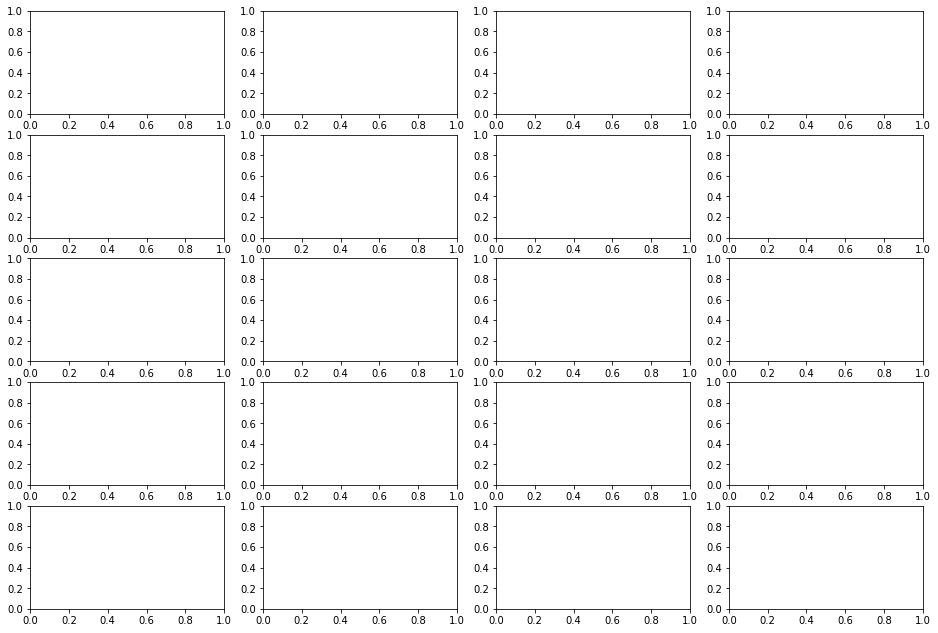

In [5]:
# obj shows the 3D object in the real world space.
obj = np.zeros((6*9,3), np.float32)
obj[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/content/drive/My Drive/Colab Notebooks/Vision/camcallib/Chess*.png')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
axs = axs.ravel()

# Find Chessboard corners for every image.
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(obj)

        imgpoints.append(corners)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        cv2.imwrite('output_images/corners_drawn'+str(i)+'.png', img)
        
print('Not all corners were found for some images')

In [6]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Vision/camcallib/Chess.png')
img_size = (img.shape[1], img.shape[0])

#Distortion & Undistortion coefficients

In [9]:
# Calibrating camera with objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img, mtx, dist):
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Saving the camera calibration matrix and coefficients for later use. Ignoring rvecs and tvecs.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

error: ignored

In [34]:
# Visualize undistortion
dst=undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
cv2.imwrite('output/original_chessboard.jpg', img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
cv2.imwrite('output/undistorted_chessboard.jpg', dst)
ax2.set_title('Undistorted Image', fontsize=30)

NameError: ignored

#Road Image Visualization (Undistortion)

In [8]:
image=mpimg.imread('test_images/test3.jpg')
undist=undistort(image,mtx,dist)
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,10))
ax1.set_title('Original Image')
ax1.imshow(image)
cv2.imwrite('output_images/original_road.jpg', image)
ax2.set_title('Undistorted Image')
ax2.imshow(undist)
cv2.imwrite('output_images/undistorted_road.jpg', undist)

FileNotFoundError: ignored

#Sobel Operations & Thresholding
1. Gradients in X or Y direction.
2. Magnitude & Direction of the gradient

In [11]:
def abs_sobel_thresh(image,orient,  thresh=(20, 100)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    if orient=='x':x, y=1,0
    else: x, y=0,1
        
    sobel=cv2.Sobel(gray,cv2.CV_64F,x,y)
    sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*sobel/np.max(sobel))
    
    sx_binary=np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])]=1
    binary_output=np.copy(sx_binary)
    return binary_output


def mag_thresh(img, mag_thresh=(20,150)):
    
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1)
    sobel=np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel=np.uint8(255*sobel/np.max(sobel))
    
#     t=sum((i > 150) &(i<200)  for i in scaled_sobel)
    binary_sobel=np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
    return binary_sobel

def dir_threshold(img,  thresh=(0.7,1.3)):
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    sobely=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    dir_=np.arctan2(sobely,sobelx)
    
    sx_binary = np.zeros_like(gray)
    sx_binary[(dir_>=thresh[0]) &(dir_<=thresh[1])]=1
    binary_output=sx_binary
    return binary_output

#Visualizing Threshold

In [14]:
sobelx=abs_sobel_thresh(image, 'x')
sobely=abs_sobel_thresh(image, 'y')
mag_sobel=mag_thresh(image)
dir_sobel=dir_threshold(image)

fig, axes=plt.subplots(1,4, figsize=(20,20))
axes=axes.ravel()

axes[0].set_title('Original Image')
axes[0].imshow(image)
axes[1].set_title('Sobel X gradient')
axes[1].imshow(sobelx, cmap='gray')
axes[2].set_title('Sobel Y gradient')
axes[2].imshow(sobely, cmap='gray')
axes[3].set_title('Magnitude Thresholding')
axes[3].imshow(mag_sobel, cmap='gray')
# axes[4].set_title('Direction Thresholding')
# axes[4].imshow(dir_sobel)

NameError: ignored

#HLS Color Channels Thresholding

In [15]:
def color_space(image,thresh=(170,255)):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    l_channel=hls[:,:,1]
    s_channel=hls[:,:,2]
    s_binary=np.zeros_like(s_channel)
    
    _, gray_binary = cv2.threshold(gray_image.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    s_binary[(s_channel>=thresh[0]) & (s_channel<=thresh[1])&(l_channel>=80)]=1
    color_output=np.copy(s_binary)
    return color_output

def segregate_white_line(image,thresh=(200,255)):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    l_channel=hls[:,:,1]
    l_binary=np.zeros_like(l_channel)
    l_binary[((l_channel>=200)&(l_channel<=255))]=1
    return l_binary


#Gradient+Color Thresholding

In [16]:
def gradient_color_thresh(image):
    ksize=3
    gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 200))
    grady = abs_sobel_thresh(image, orient='y', thresh=(20, 200))
    
    mag_binary = mag_thresh(image, mag_thresh=(20, 200))
    
    dir_binary = dir_threshold(image, thresh=(0.7, 1.3))
    
    color_binary=color_space(image,thresh=(100,255))
    
    combined = np.zeros_like(dir_binary)
    combined[(color_binary==1)|((gradx == 1)& (grady == 1)) |(mag_binary==1) &(dir_binary==1)] = 1
    
    kernel = np.ones((3,3),np.uint8)
    morph_image=combined[600:,:950]
    morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
    combined[600:,:950]=morph_image
    
    white_line=segregate_white_line(image,thresh=(200,255))
    combined=(combined)|(white_line)
    
    return combined

#Test

In [17]:
thresh_image=gradient_color_thresh(undist)
plt.imshow(thresh_image, cmap='gray')
plt.axis('off')
cv2.imwrite('output_images/gradient_color_thresh.jpg', thresh_image)

NameError: ignored

#Prespective Transformation

In [ ]:
def perspective_transform(image):
    src=np.float32([[195,720],[590,460],[700,460],[1120,720]])
    dst=np.float32([[350,720],[410,0],[970,0],[1000,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size=(image.shape[1],image.shape[0])
    print(M.shape,Minv.shape)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv,M

#Visualize

In [ ]:
binary_warped,Minv,M=perspective_transform(thresh_image)
plt.imshow(binary_warped, cmap='gray')
plt.axis('off')

#Data Storage (Line Class)

In [18]:
class line():
    def __init__(self):
        self.first_frame=False
        self.curvature=0
        
        self.right_fit=[np.array([False])]
        self.left_fit=[np.array([True])]
        self.max_tolerance=0.01
        
        self.img=None
        self.y_eval=700
        self.mid_x=640
        self.ym_per_pix=3.0/72.0
        self.xm_per_pix=3.7/650.0 #HardCoded
    
    def update_fit(self,left_fit,right_fit):
        if self.first_frame:
            error_left=((self.left_fit[0]-left_fit[0])**2).mean(axis=None)
            error_right=((self.right_fit[0]-right_fit[0])**2).mean(axis=None)
            if error_left<self.max_tolerance:
                self.left_fit=0.75*self.left_fit+0.25*left_fit
            if error_right<self.max_tolerance:
                self.right_fit=0.75*self.right_fit+0.25*right_fit
        
        else:
            self.right_fit=right_fit
            self.left_fit=left_fit
        
        self.update_curvature(self.right_fit)
        
    def update_curvature(self,fit):
        
        c1=(2*fit[0]*self.y_eval+fit[1])*self.xm_per_pix/self.ym_per_pix
        c2=2*fit[0]*self.xm_per_pix/(self.ym_per_pix**2)
        
        curvature=((1+c1*c1)**1.5)/(np.absolute(c2))
        
        if self.first_frame:
            self.curvature=curvature
        
        elif np.absolute(curvature-self.curvature)<500:
            self.curvature=0.75*self.curvature + 0.25* curvature
        
    def vehicle_position(self):
        left_pos=(self.left_fit[0]*(self.y_eval**2))+(self.left_fit[1]*self.y_eval)+self.left_fit[2]
        right_pos=(self.right_fit[0]*(self.y_eval**2))+(self.right_fit[1]*self.y_eval)+self.right_fit[2]
        
        return ((left_pos+right_pos)/2.0 - self.mid_x)*self.xm_per_pix

#Pipeline

In [19]:
class pipeline:
    line=None
    M=None
    Minv=None
    camera_mtx=None
    dist=None
    
    @staticmethod
    def set_vals(l,camera_mtx,dist,m,minv):
        pipeline.line=l
        pipeline.camera_mtx=camera_mtx
        pipeline.dist=dist
        pipeline.M=M
        pipeline.Minv=Minv
    
    @staticmethod
    def Pipeline(img):
        line,M,Minv,camera_mtx,dist=pipeline.line,pipeline.M,pipeline.Minv,pipeline.camera_mtx,pipeline.dist
        
        img_size=(img.shape[1],img.shape[0])
        width,height=img_size
        
        undist_img=undistort(np.copy(img),camera_mtx,dist)
        thresh_image=gradient_color_thresh(undist_img)
        
        binary_warped = cv2.warpPerspective(thresh_image, M, img_size, flags=cv2.INTER_LINEAR)
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        nwindows = 9
        
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        margin = 100
        minpix=50
        
        if not line.first_frame:
            histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
            # Create an output image to draw on and  visualize the result
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            line.update_fit(left_fit,right_fit)
            line.first_frame=True
            
        else:
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            left_fit=line.left_fit
            right_fit=line.right_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            line.update_fit(left_fit,right_fit)
            left_fit=line.left_fit
            right_fit=line.right_fit
         
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        dx=line.vehicle_position()
        if dx>0:
            text='Left'
        else:
            text='Right'
        
        cv2.putText(result,'Radius of curvature  = %.2f m'%(line.curvature),(20,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), text),(20,90),
                        font, 1,(255,255,255),2,cv2.LINE_AA)
        return result

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2514944/45929032 bytes (5.5%)5808128/45929032 bytes (12.6%)9265152/45929032 bytes (20.2%)12722176/45929032 bytes (27.7%)16138240/45929032 bytes (35.1%)19193856/45929032 bytes (41.8%)22462464/45929032 bytes (48.9%)25796608/45929032 bytes (56.2%)28893184/45929032 bytes (62.9%)31580160/45929032 bytes (68.8%)34807808/45929032 bytes (75.8%)38133760/45929032 bytes (83.0%)

In [21]:
line_=line()
pipeline.set_vals(line_,mtx,dist,M,Minv)
video_output = 'video3.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
video_clip = clip1.fl_image(pipeline.Pipeline)
%time video_clip.write_videofile(video_output, audio=False)

NameError: ignored